In [ ]:
I'd like to spend some time closing the section on linear and logistic regression by highlighting two things: <b> feature scaling </b> and <b> creating new hypothesis functions</b>.

Recall the hypothesis for linear regression:

$$h_\theta(x) = \theta^T X$$
$$h_\theta(x) = \sum_{i=0}^{n}\theta_i x_i$$
$$h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + ...  + \theta_n x_n$$

In other words, for each sample and dimension of X, we have a weight. When we get to <b> multivariate linear regression</b> where each dimension has a different range of values, we may get to the following scenario.

In [1]:
from IPython.display import display, Image
display(Image(url='http://img.blog.csdn.net/20131122160523546?I0JBQkFCMA==/dissolve/70/gravity/SouthEast'))

Clearly, the image on the right side is easier for gradient descent optimizers to solve. To achieve this, we must make the data have approximately 0 mean. <b>For each dimension other than x0, we get its mean and divide by its standard deviation</b>. This can be done easily in sklearn as we shall see later.

$$ x_i = \frac{x_i - \mu_i}{\sigma_1} $$

# New Hypothesis Functions

We can transform the following hypothesis:

$$h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2$$

... to higher order polynomials by putting additional terms.

$$h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_1^2 + \theta_4 x_2^2$$

We can even add interaction terms like the following:

$$h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_1^2 + \theta_4 x_2^2 + \theta_5 x_1 x_2$$

We'll do that in sklearn and summon again our board game dataset.

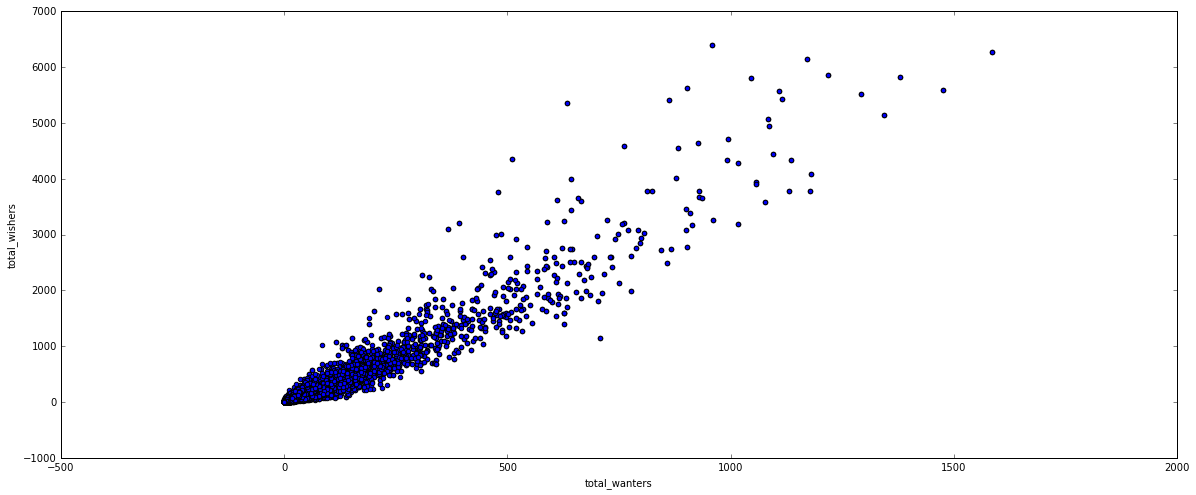

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

board_data = pd.read_csv('data/games.csv')
board_data = board_data[\
            board_data["average_rating"] > 0]
data_wanters_wishers = board_data[\
            ['total_wanters', 'total_wishers']]

subplot = data_wanters_wishers.plot(
    kind='scatter',x='total_wanters', 
    y='total_wishers', figsize=(20,8))

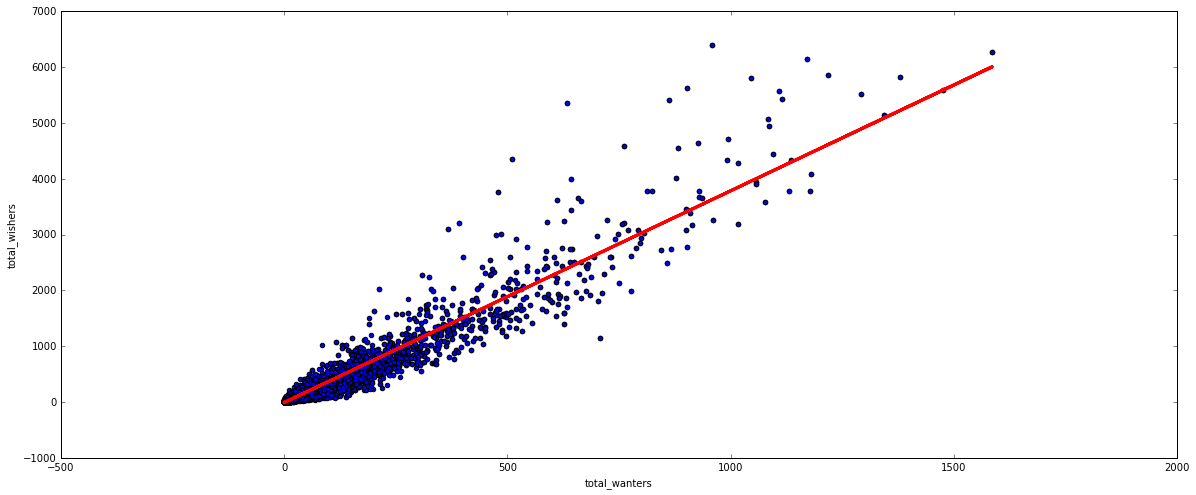

In [3]:
from sklearn import linear_model

X_orig= board_data["total_wanters"].as_matrix().reshape(-1,1).astype(np.float32)
y_orig= board_data["total_wishers"].as_matrix()
linres = linear_model.LinearRegression()
linres.fit(X_orig, y_orig)
predictions = linres.predict(X_orig)

subplot = data_wanters_wishers.plot(
    kind='scatter',x='total_wanters', 
    y='total_wishers', figsize=(20,8))

subplot.plot(X_orig, predictions, color='red', 
             linewidth=3)
plt.show()

Let's try the polynomial kernel, which converts the hypothesis to arbitrary higher order polynomials.

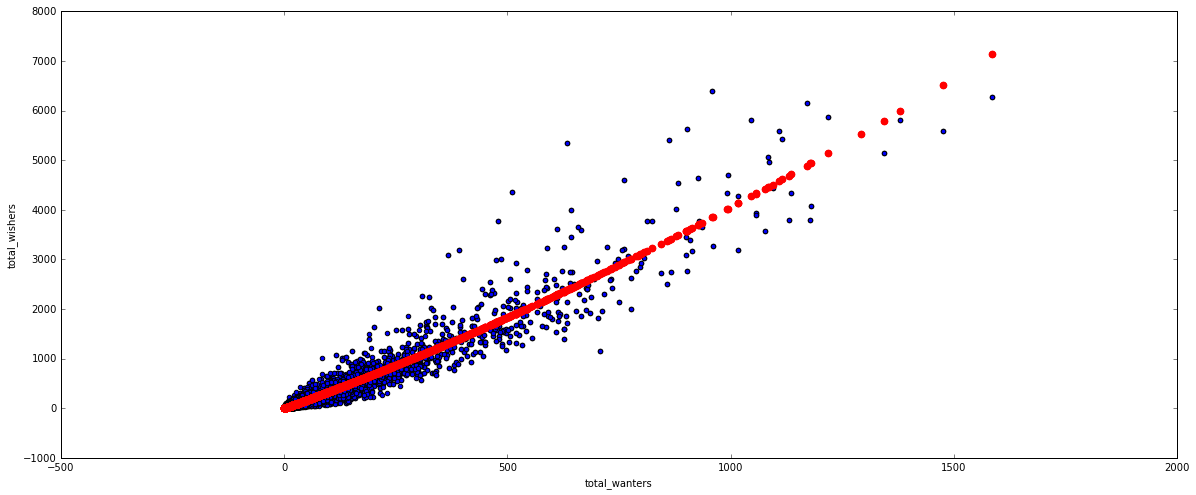

In [4]:
from sklearn import preprocessing
poly = preprocessing.PolynomialFeatures(degree=2)
y_orig= board_data["total_wishers"].as_matrix()
X_higher = poly.fit_transform(X_orig)

linres = linear_model.LinearRegression()
linres.fit(X_higher, y_orig)
predictions = linres.predict(X_higher)

subplot = data_wanters_wishers.plot(
    kind='scatter',x='total_wanters', 
    y='total_wishers', figsize=(20,8))

subplot.scatter(X_higher[:,1], predictions, color='red', 
             linewidth=3)
plt.show()

In [7]:
X_orig[:5]

array([[ 1219.],
       [ 1586.],
       [ 1476.],
       [ 1084.],
       [  861.]], dtype=float32)

In [6]:
X_higher[:5]

array([[  1.00000000e+00,   1.21900000e+03,   1.48596100e+06],
       [  1.00000000e+00,   1.58600000e+03,   2.51539600e+06],
       [  1.00000000e+00,   1.47600000e+03,   2.17857600e+06],
       [  1.00000000e+00,   1.08400000e+03,   1.17505600e+06],
       [  1.00000000e+00,   8.61000000e+02,   7.41321000e+05]], dtype=float32)

In fact, here's a subplot comparison of degrees [2,6]. I will also include a test set for the metrics.

/home/dylan/GitHub/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


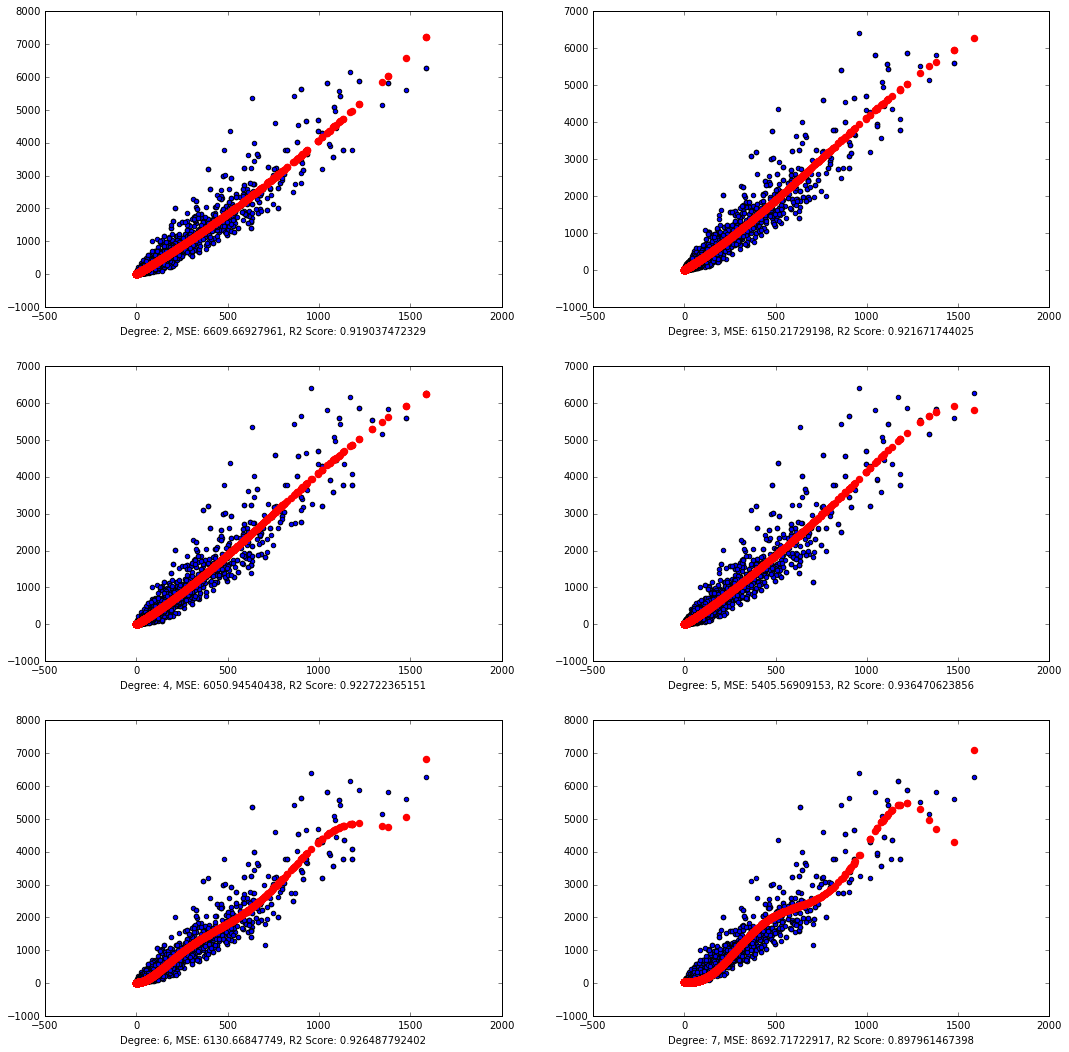

In [8]:
from sklearn import linear_model, metrics, cross_validation

fig, axes = plt.subplots(3,2, figsize=(18,18))
degree = 2

for i in range(3):
    for j in range(2):
        poly = preprocessing.PolynomialFeatures(degree=degree)
        degree+=1
        # polynomial features
        X_higher = poly.fit_transform(X_orig)
        # train test split
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(
            X_higher, y_orig, test_size=0.33)

        linres = linear_model.LinearRegression()
        linres.fit(X_train, y_train)
        predictions_on_train = linres.predict(X_train)
        predictions_on_test = linres.predict(X_test)
        r2_score = metrics.r2_score(y_test, predictions_on_test)
        mse = metrics.mean_squared_error(y_test, predictions_on_test)
                
        axes[i][j].scatter(X_train[:,1], y_train)
        axes[i][j].scatter(X_train[:,1], predictions_on_train, color='red', 
                     linewidth=3)
        axes[i][j].set_xlabel("Degree: {}, MSE: {}, R2 Score: {}".format(degree-1, mse, r2_score))
        
plt.show()

As you can see, higher degrees could help, but only to an extent. There is some point where the lines become so absurd that the model <b> learns the noise</b> instead of the stark obvious patterns in the data. We segue to the bias-variance problem.

# The Bias Variance Tradeoff

The bias-variance tradeoff is a fundamental concept in machine learning. It can be explained in several perspectives. Let's go with the easiest to the hardest. See this site for an amazing explanation : http://scott.fortmann-roe.com/docs/BiasVariance.html

### Impact on training and test set

In [9]:
from IPython.display import display, Image
display(Image(url='https://blog.fliptop.com/wp-content/uploads/2015/03/highvariance-300x254.png',
             width=512,height=256))

When we ramp up the model complexity, we can inevitably better model the training set. However, the model learns the noise in the data that contribute negatively to the performance on unseen examples. This is clearly seen above, as we add more higher order polynomial terms, we model absurd curves on the training set.

### Definition by concept

The right side of the above graph is called <b> high variance</b>. The left side is called <b>high bias</b>. 
    
(1) Error due to Bias: The error due to bias is taken as the difference between the expected (or average) prediction of our model and the correct value which we are trying to predict. Of course you only have one model so talking about expected or average prediction values might seem a little strange. However, imagine you could repeat the whole model building process more than once: each time you gather new data and run a new analysis creating a new model. Due to randomness in the underlying data sets, the resulting models will have a range of predictions. <b>Bias measures how far off in general these models' predictions are from the correct value. </b>
    
(2) Error due to Variance: The error due to variance is taken as the variability of a model prediction for a given data point. <b> Again, imagine you can repeat the entire model building process multiple times. The variance is how much the predictions for a given point vary between different realizations of the model.</b>


### Definition by bulls eye

In [10]:
from IPython.display import display, Image
display(Image(url='http://blog.fliptop.com/wp-content/uploads/2015/01/Bias_Variance.jpg',
             width=512,height=256))

1) <b>Low variance, low bias</b>: All shots are on point. All's right with the world.

2) <b>Low variance, high bias</b>: All attempts are not going through. Always. #Hugot. You may be modeling an inherently nonlinear problem (interest rates?) using only lines.

3) <b>High variance, low bias</b>: Some attempts are not going through. Try harder. #Hugot. These are your complex models like decision trees, SVM's, neural networks. This is why you can't just feed data to the most powerful classifier in the world and expect great results.

4) <b>High variance, high bias</b>: Typically, the model has yet to converge.

### Definition by Math

$$Err(x) = E\left[(Y-\hat{f}(x))^2\right]$$

$$Err(x) = \left(E[\hat{f}(x)]-f(x)\right)^2 + E\left[\left(\hat{f}(x)-E[\hat{f}(x)]\right)^2\right] +\sigma_e^2$$

$$Err(x) = \mathrm{Bias}^2 + \mathrm{Variance} + \mathrm{Irreducible\ Error}$$

# Regularization

But we can have a very complex model but include "regularization" techniques to reduce variance. One such technique is using L1 normalization (Lasso Regression) or L2 normalization (Ridge Regression).

For L1 normalization we add an additional penalty term on the optimization objective:
$$J_{reg}(\theta,y) = \frac{1}{2} \sum_{i=0}^{m}(h_\theta(x^{(i)}) - y^{(i)}) + \alpha\sum_{i=1}^{n} ||\theta_j||$$

For L2, we add an additional penalty term on the optimization objective:
$$J_{reg}(\theta,y) = \frac{1}{2} \sum_{i=0}^{m}(h_\theta(x^{(i)}) - y^{(i)}) + \alpha\sum_{i=1}^{n} \theta_j^2$$

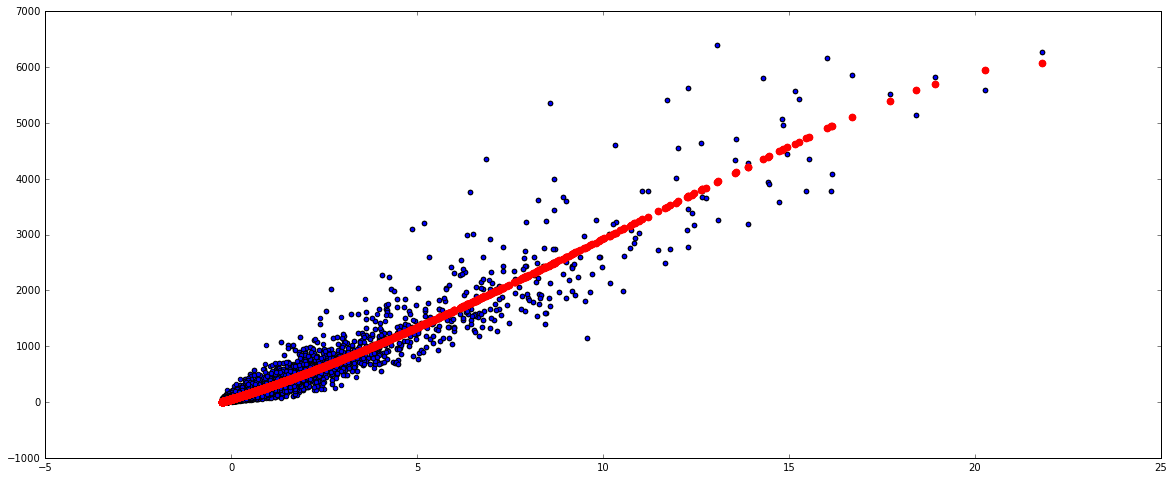

In [19]:
from sklearn.pipeline import Pipeline
from sklearn import cross_validation as cv

# train test split
X_orig= board_data["total_wanters"].as_matrix()\
                .reshape(-1,1).astype(np.float32)
y_orig= board_data["total_wishers"].as_matrix()
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X_orig)
X_7 = preprocessing.PolynomialFeatures(degree=7).fit_transform(X_norm)

lasso = linear_model.Lasso(alpha=2)
lasso.fit(X_7, y_orig)
predictions = lasso.predict(X_7)

plt.figure(figsize=(20,8))
plt.scatter(X_7[:,1], y_orig)
plt.scatter(X_7[:,1], predictions, color='red', linewidth=3)

# print("R2 scores: {}".format(cv.cross_val_score(lasso, X_7, y_orig, scoring='r2')))
# print("MSE scores: {}".format(cv.cross_val_score(lasso, X_7, y_orig, scoring='mean_squared_error')))

## Go ahead and modify the alpha function. What do you see?

In [21]:
np.logspace(-3, 2, 6)

array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02])

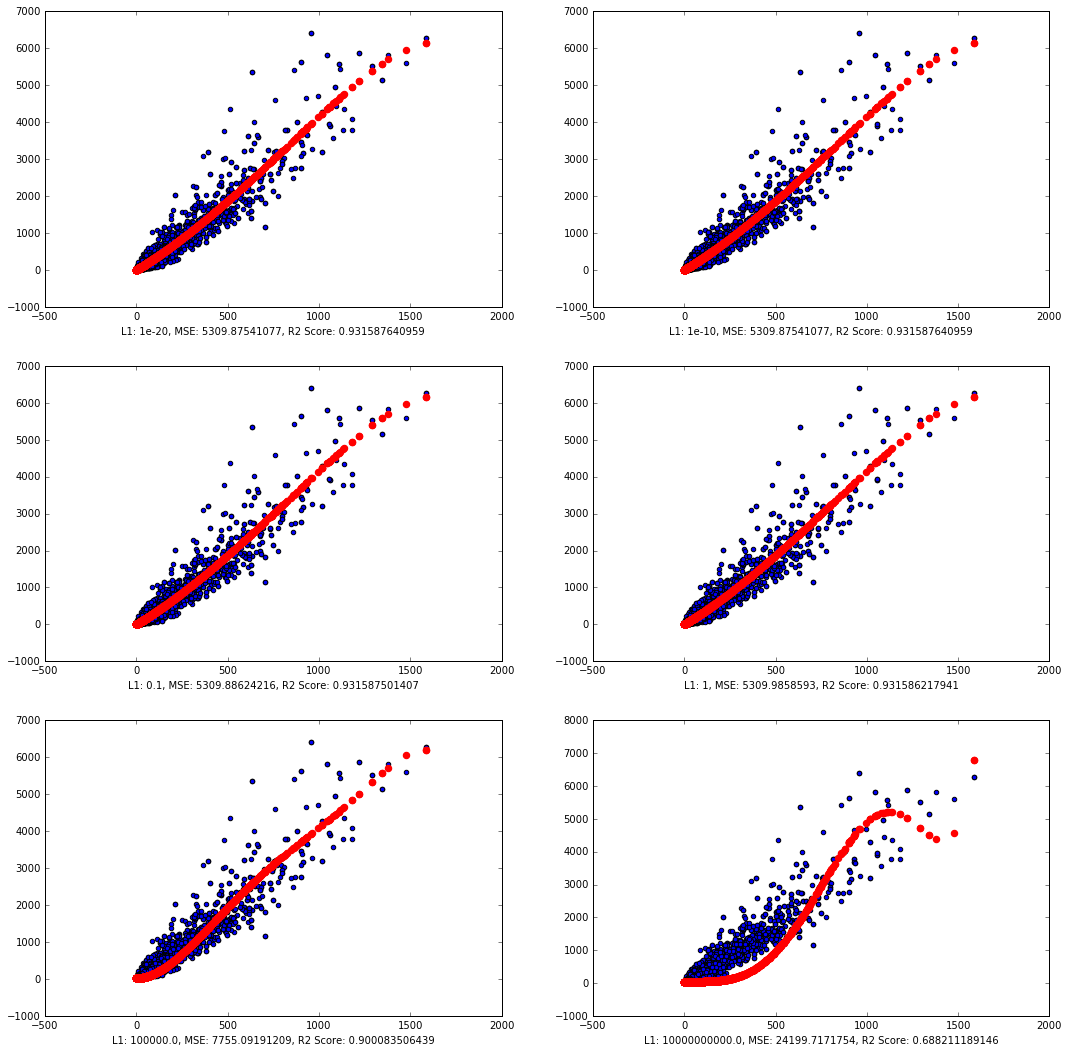

In [22]:
from sklearn import linear_model, metrics, cross_validation

fig, axes = plt.subplots(3,2, figsize=(18,18))
# alpha_range = np.logspace(-3, 2, 6)
alpha_range = [1e-20, 1e-10,1e-1,1, 1e5, 1e10]
idx=0
for i in range(3):
    for j in range(2):
        poly = preprocessing.PolynomialFeatures(degree=7)
        # polynomial features
        X_higher = poly.fit_transform(X_orig)
        # train test split
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(
            X_higher, y_orig, test_size=0.33, random_state=1)

        lasso = linear_model.Lasso(alpha=alpha_range[idx])
        idx+=1
        lasso.fit(X_train, y_train)
        predictions_on_train = lasso.predict(X_train)
        predictions_on_test = lasso.predict(X_test)
        r2_score = metrics.r2_score(y_test, predictions_on_test)
        mse = metrics.mean_squared_error(y_test, predictions_on_test)
                
        axes[i][j].scatter(X_train[:,1], y_train)
        axes[i][j].scatter(X_train[:,1], predictions_on_train, color='red', 
                     linewidth=3)
        axes[i][j].set_xlabel("L1: {}, MSE: {}, R2 Score: {}".format(
                alpha_range[idx-1], mse, r2_score))
        
plt.show()

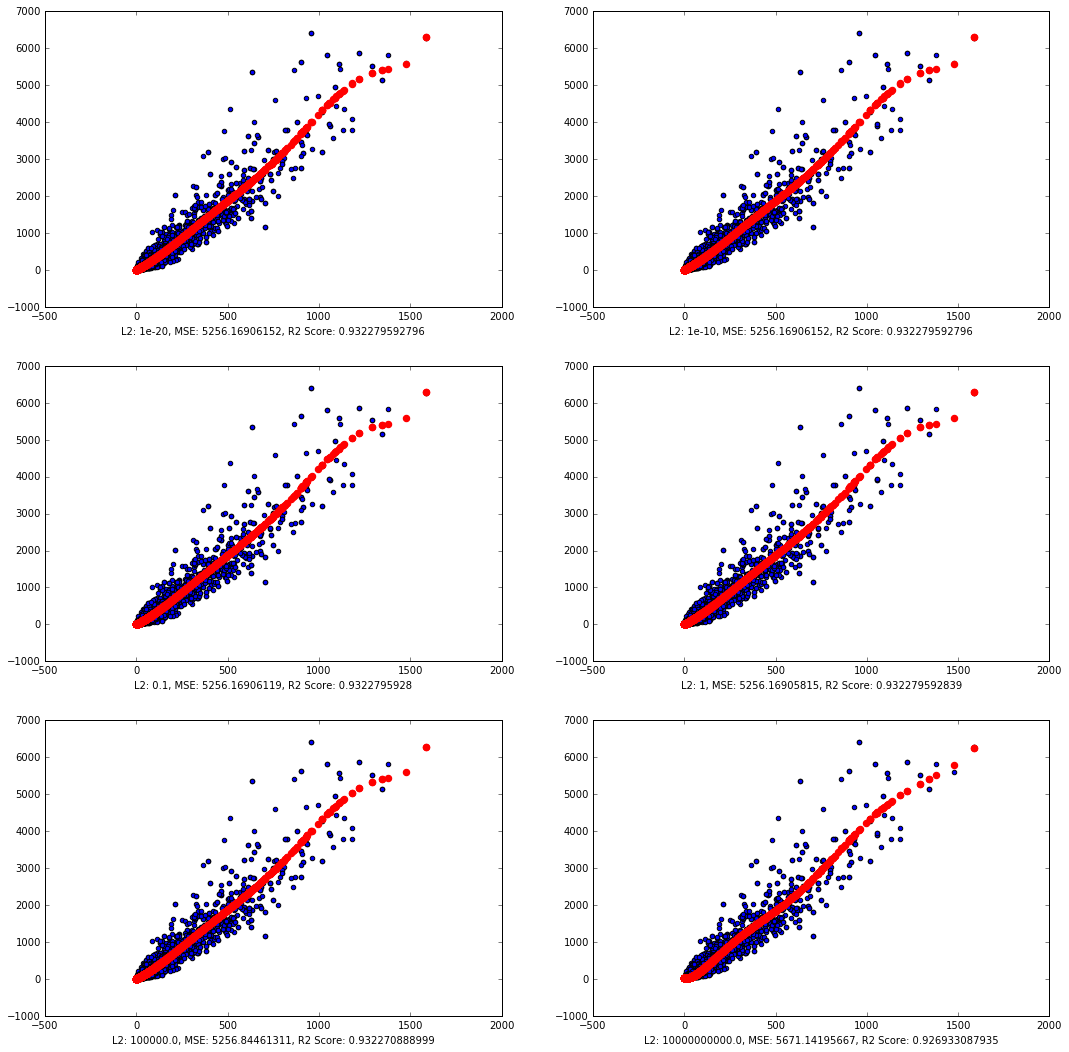

In [23]:
from sklearn import linear_model, metrics, cross_validation

fig, axes = plt.subplots(3,2, figsize=(18,18))
# alpha_range = np.logspace(-3, 2, 6)
alpha_range = [1e-20, 1e-10,1e-1,1, 1e5, 1e10]
idx=0
for i in range(3):
    for j in range(2):
        poly = preprocessing.PolynomialFeatures(degree=7)
        # polynomial features
        X_higher = poly.fit_transform(X_orig)
        # train test split
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(
            X_higher, y_orig, test_size=0.33, random_state=1)

        lasso = linear_model.Ridge(alpha=alpha_range[idx])
        idx+=1
        lasso.fit(X_train, y_train)
        predictions_on_train = lasso.predict(X_train)
        predictions_on_test = lasso.predict(X_test)
        r2_score = metrics.r2_score(y_test, predictions_on_test)
        mse = metrics.mean_squared_error(y_test, predictions_on_test)
                
        axes[i][j].scatter(X_train[:,1], y_train)
        axes[i][j].scatter(X_train[:,1], predictions_on_train, color='red', 
                     linewidth=3)
        axes[i][j].set_xlabel("L2: {}, MSE: {}, R2 Score: {}".format(
                alpha_range[idx-1], mse, r2_score))
        
plt.show()

# Can I do the higher order polynomial features automatically?

The trouble of using higher order polynomial terms is computational explosion. If we have 1000 dimensions, then imagine doubling that. If we have interaction terms, then the number of terms becomes >> 3.297886364 E+1433 $$ \sum_{i=2}^{n-1}\dbinom{n}{i} $$

But we may only need a few of those terms right? Well, enter neural networks. Neural networks were very widely used in 80's and the early 90's, but was supplanted by SVM's and later on, Random Forests. But now, deep learning has broken a lot of benchmarks especially in computer vision, speech recognition and to a lesser extent, NLP. But first, let's go with the motivations.

(Original source: https://d396qusza40orc.cloudfront.net/ml/docs/slides/Lecture8.pdf)

(Watch videos here: https://class.coursera.org/ml-005/lecture (Week 4 and Week 5)

In [24]:
from IPython.display import display, Image
display(Image(url='http://image.slidesharecdn.com/deeplearningpresentation-\
150419141136-conversion-gate02/95/deep-learning-presentation-7-638.jpg?cb=1429452770',))

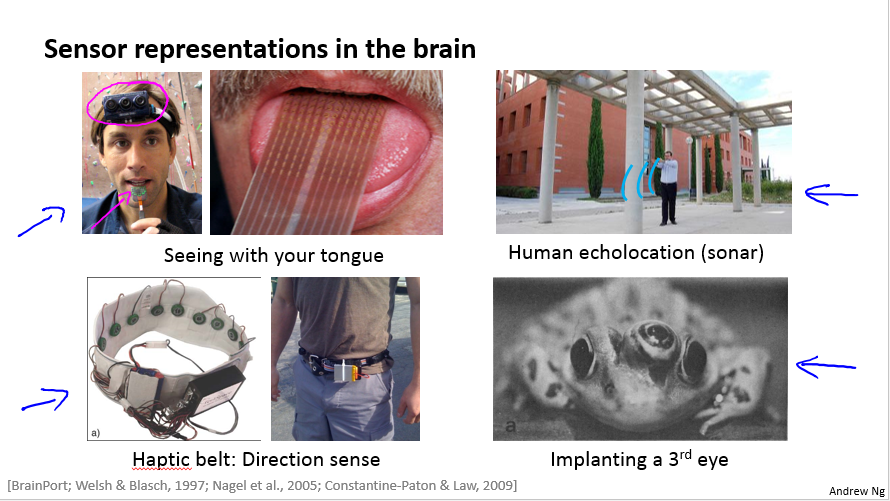

In [25]:
from IPython.display import display, Image
display(Image("images/sensory_re.PNG"))

## Biological intution:

Neural networks are simpler versions of the biological brain, but the principle holds. We have units that pass along signals along connections. These connections are representative of the patterns we discover in the data.

In [26]:
from IPython.display import display, Image
display(Image(url='http://webspace.ship.edu/cgboer/neuron.gif',
             width=512,height=256))

## From regression intuition:

If we remove the middle <b> hidden layer </b>we end up with logistic regression. Having the hidden layer combines the features themselves into interaction units. It may even make the functions into higher order polynomials.

In [27]:
from IPython.display import display, Image
display(Image(url='http://scikit-learn.org/dev/_images/multilayerperceptron_network.png',
             width=512,height=256))

## Mathematical intuition:

We are discovering intermediate functions that transform x. In the image below, we have

$$a_{lk}^{(1)} = \sum_{k=0}^mg(\Theta_{lk}^{(1)} x_k)$$

... where the sigmas are like intermediate functions that form the final output:

$$ f(x) = \Theta_1(\Theta_2(...(\Theta_r(x))) $$

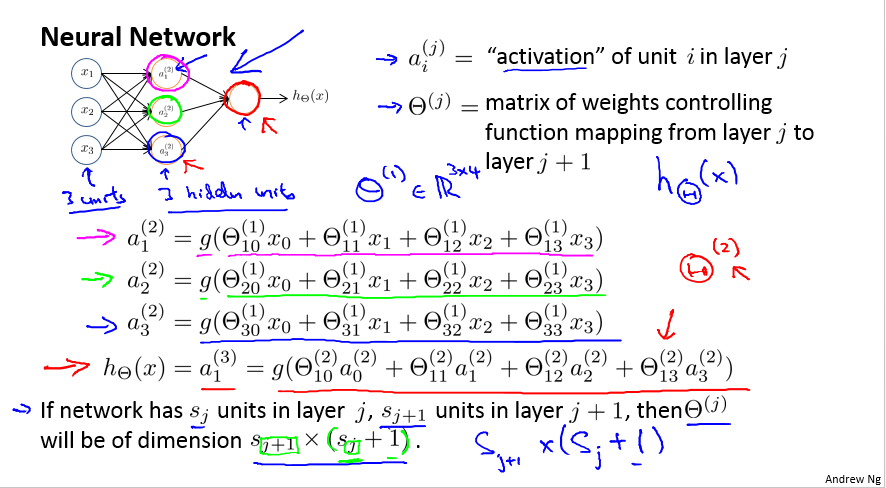

In [28]:
from IPython.display import display, Image
display(Image("images/forward_prop.PNG"))

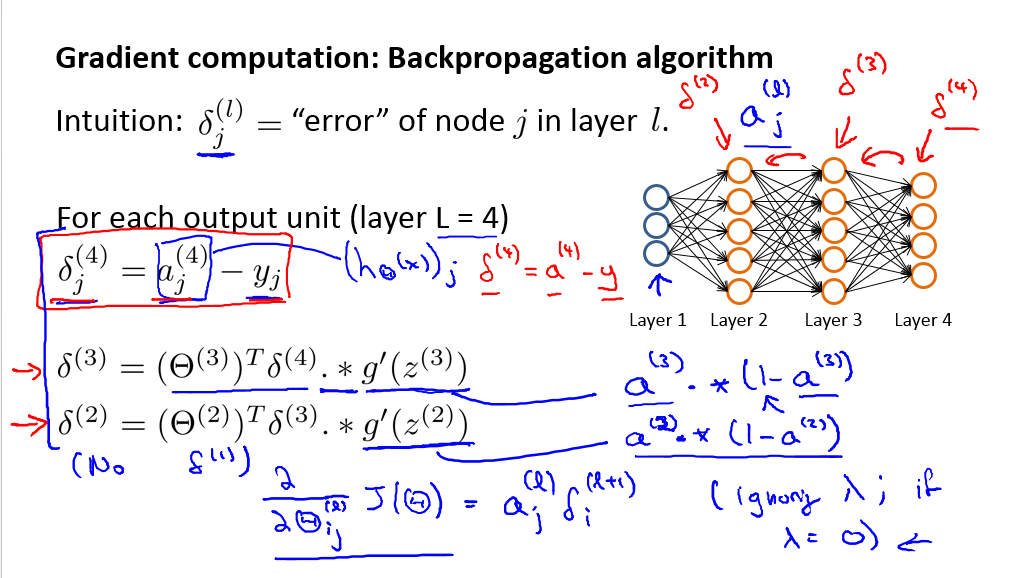

In [40]:
from IPython.display import display, Image
display(Image("images/back_prop.PNG"))

What's g(z) then? It is a nonlinear function that maps z to another value. These nonlinearities are important since it affects optimization and the architecture of the network.<b> Without nonlinearities, having multiple hidden layers is equivalent to just having one</b>.

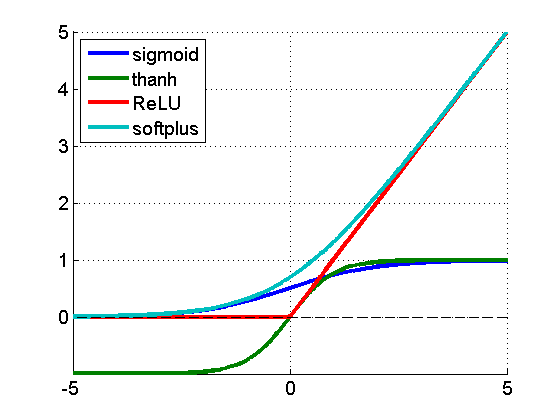

In [29]:
from IPython.display import display, Image
display(Image("images/nonlinearities.png"))

# Let's load up a non-linearly separable dataset

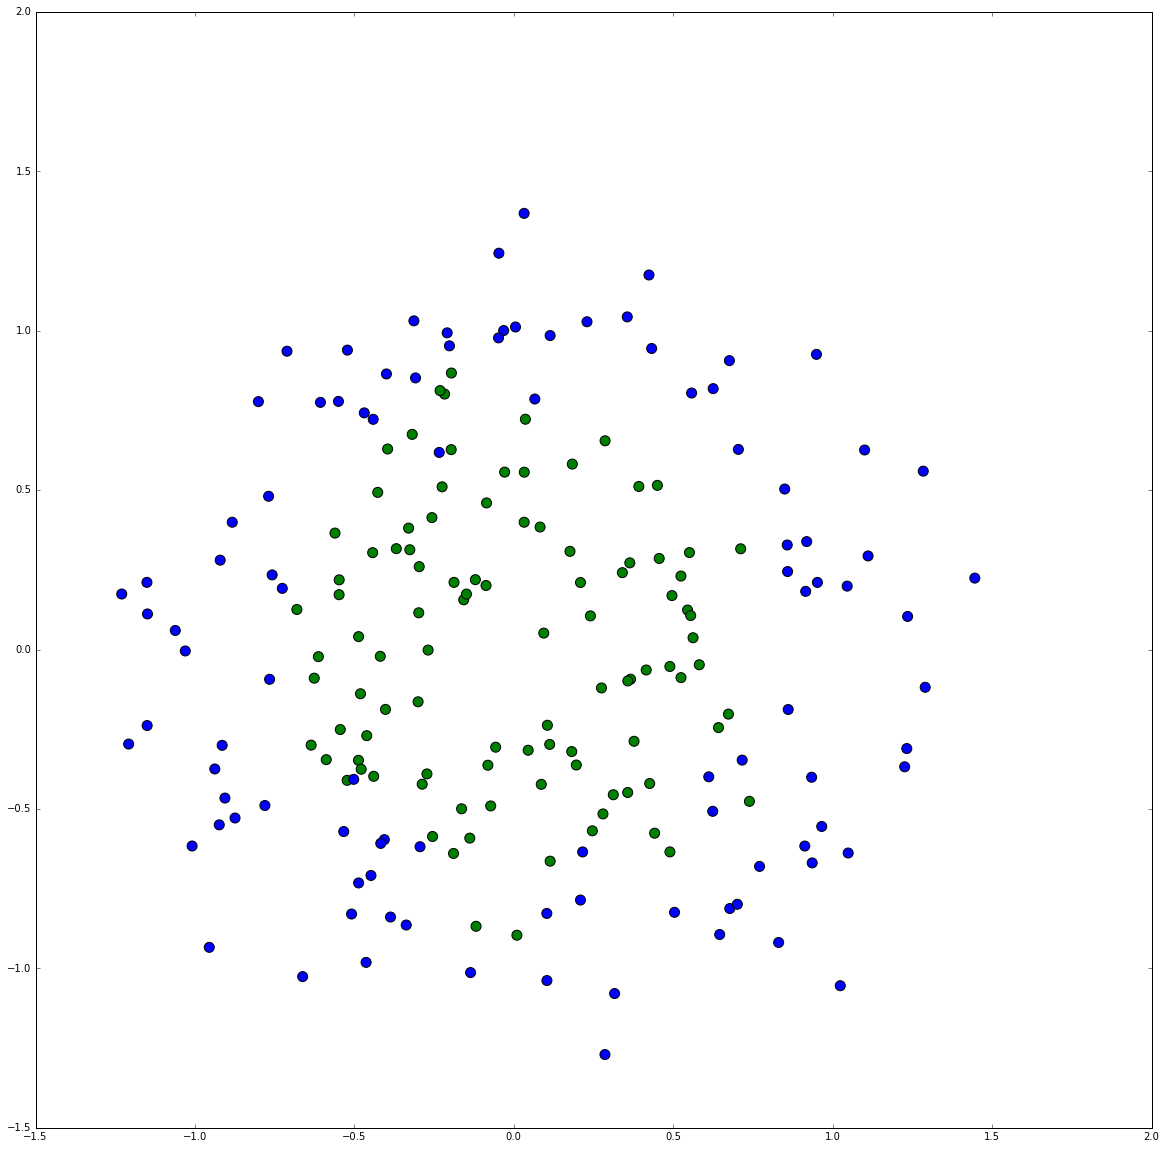

In [30]:
from sklearn import datasets, neural_network
dataset = datasets.make_circles(n_samples=200, 
                                noise=0.2, 
                                factor=0.5, 
                                random_state=1)
X = np.asarray(dataset[0])
y = np.asarray(dataset[1])
plt.figure(figsize=(20,20))
color_wheel = {0: "blue", 1:"green"}

plt.scatter(X[:,0],X[:,1], 
            c=map(lambda x:color_wheel[x], y), s=100)

In [37]:
clf = neural_network.MLPClassifier(algorithm='l-bfgs', 
                                   alpha=1e-5, 
                                   hidden_layer_sizes=(10,), 
                                   random_state=1)
clf.fit(X, y)
# from sklearn import metrics
cross_validation.cross_val_score(clf, X, y)

array([ 0.92647059,  0.92424242,  0.90909091])

## Q: Plot the Neural Network as the hidden layer size increase.

## Neural nets: Pros, Cons
From Sklearn:

The advantages of Multi-layer Perceptron are:

1) Capability to learn non-linear models.

2) Capability to learn models in real-time (on-line learning) using partial_fit.

3) With deep learning, even the features and the nonlinearities themselves could be learned a-la one learning hypothesis.

The disadvantages of Multi-layer Perceptron (MLP) include:

1) MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.

2) MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.

3) MLP is sensitive to feature scaling.

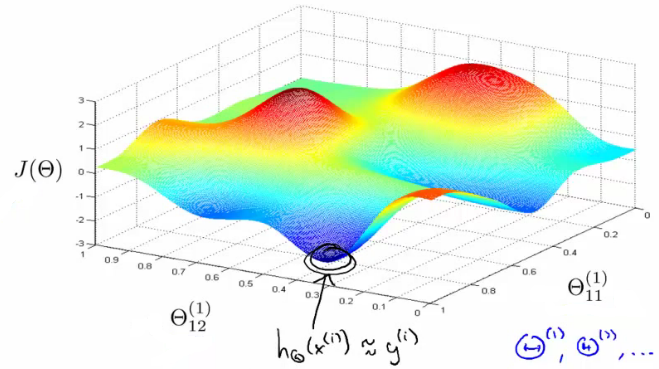

In [38]:
from IPython.display import display, Image
display(Image("http://www.holehouse.org/mlclass/09_Neural_Networks_Learning_files/Image%20%5B35%5D.png"))

# Support Vector Machines

SVM's are powerful machine learning algorithms that can be used for classification, regression and outlier detection. For the classification case, SVM's focus on <b>finding the maximum separating hyperplane on a high dimensional to infinite space</b>. The appeal of SVM's lie both in its analytical soundness and empirical results, and this is why from the 90's up to today, we still have SVM's as one of the most valuable tools in our machine learning arsenal.

There is a lot of mathematics and optimization involved to learn it so we'll be sticking to intuitions and jumping on material from Andrew Ng's class.

In [41]:
from IPython.display import display, Image
display(Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Svm_intro.svg/2000px-Svm_intro.svg.png"))

In [42]:
from IPython.display import display, Image
display(Image(url="http://images.slideplayer.com/16/4877254/slides/slide_9.jpg"))

In [43]:
from IPython.display import display, Image
display(Image(url="http://www.eric-kim.net/eric-kim-net/posts/1/imgs/data_2d_to_3d_hyperplane.png"))

## More?
Now this is the point where I share the actual slides for more information.

https://d396qusza40orc.cloudfront.net/ml/docs/slides/Lecture12.pdf

## SVM's: Pros, Cons

The advantages of support vector machines are:

1) Effective in high dimensional spaces.

2) Still effective in cases where number of dimensions is greater than the number of samples.

3) Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

4) Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

1) If the number of features is much greater than the number of samples, the method is likely to give poor performances.

2) SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.



In [48]:
from sklearn import svm
def plot_data(X, y):
    hidden_units = 10
    C = 10.0
    svc = svm.SVC(kernel='linear', C=C).fit(X, y)
    rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
    poly_svc = svm.SVC(kernel='poly', degree=7, C=C).fit(X, y)
    nn = neural_network.MLPClassifier(
        algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(hidden_units,), random_state=1).fit(X,y)

    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # title for the plots
    titles = ['SVC with linear kernel',
              'Neural network with {} hidden units'.format(hidden_units),
              'SVC with RBF kernel',
              'SVC with polynomial (degree 3) kernel']

    plt.figure(figsize=(20,20))
    for i, clf in enumerate((svc, nn, rbf_svc, poly_svc)):
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        plt.subplot(2, 2, i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])

    plt.show()

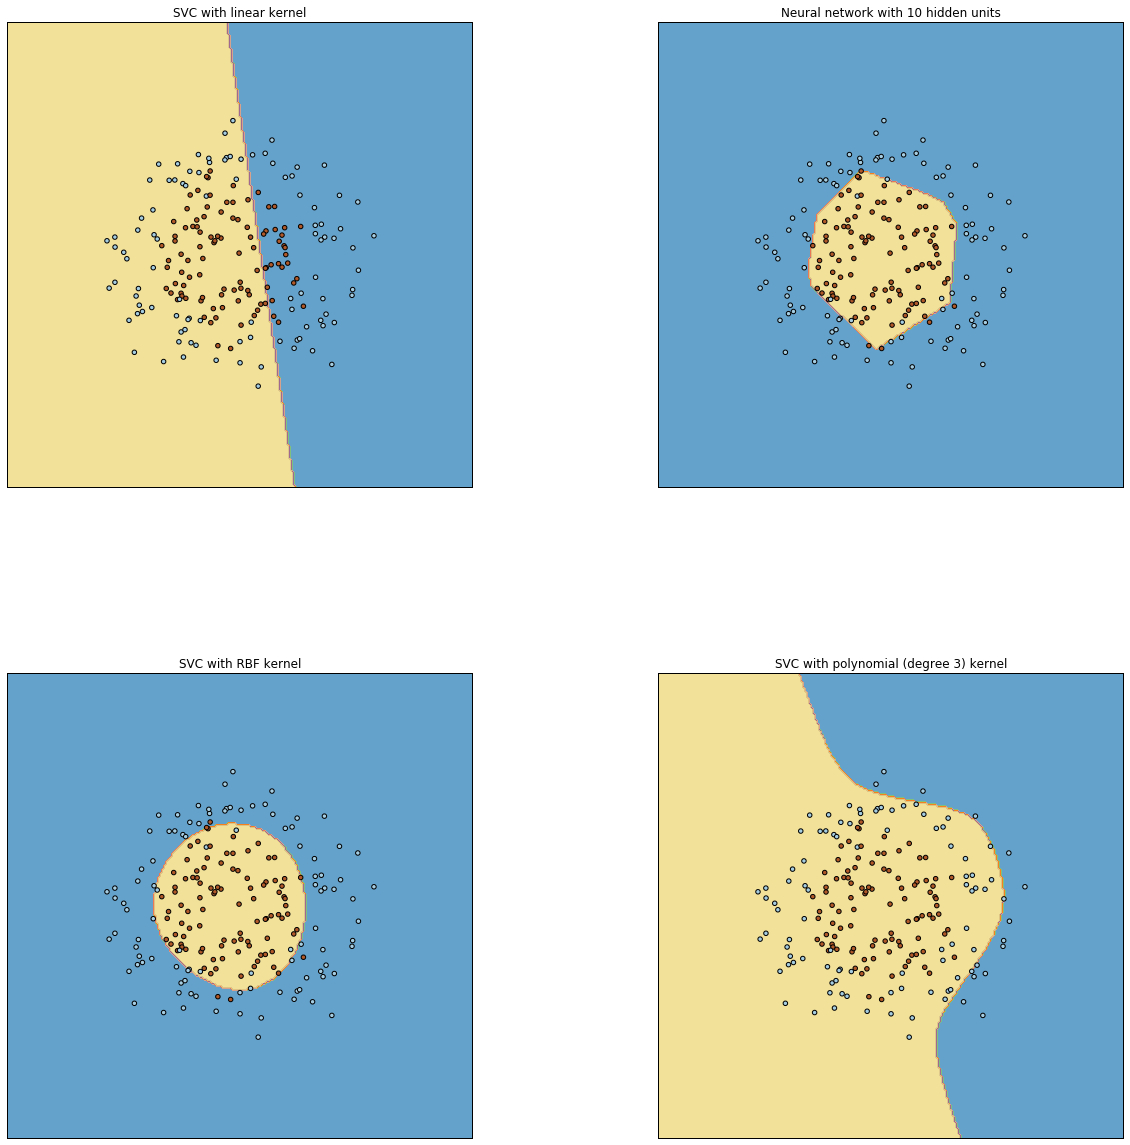

In [49]:
plot_data(X,y)

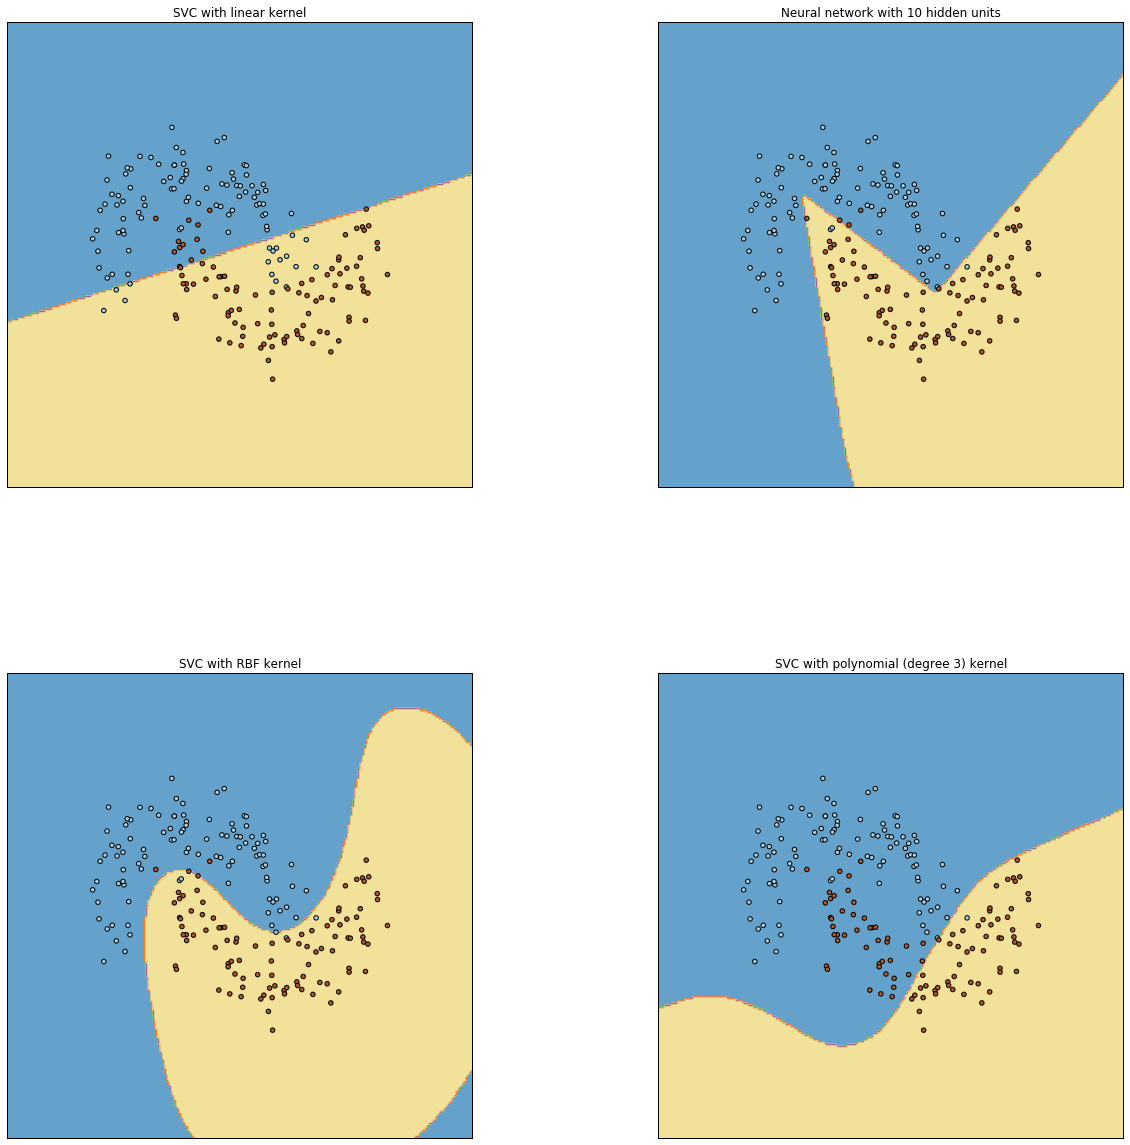

In [50]:
dataset = datasets.make_moons(n_samples=200, noise=0.2, random_state=1)
X = np.asarray(dataset[0])
y = np.asarray(dataset[1])
plot_data(X,y)

## Homework

1) Use these techniques for the titanic dataset then submit. Report results at the start of the report next week.

2) Read these papers (draw lots). Report next week. 5 minutes each, 1 minute Q&A:
    
    a) Detection of Spyware by Mining Executable Files (Shazhad, Haider & Lavesson)
    
    b) Real-time Classification of Malicious URLs on Twitter using Machine Activity Data (Burnap et. al)
    
    c) Learning to Detect Malicious Executables (Kolter, Maloof)
    
    d) Beyond Blacklists: Learning to Detect Malicious Web Sites from Suspicious URLs (Voelker et. al)
    
    e) Static Detection of Malicious JavaScript-Bearing PDF Documents (Šrndic and Laskov)
    
    f) A Performance Evaluation of Machine Learning-Based Streaming Spam Tweets Detection (Chen et al)
    



    g) Identifying Suspicious URLs: An Application of Large-Scale Online Learning (Voelker, et al)